In [1]:
%matplotlib notebook
# %matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from functools import partial

### Kernels and their derivatives w.r.t parameters

In [2]:
def sqexp(x, xp, params):#tau1=1.0,tau2 = 1.0, l1=3.0, l2=2.0):
    """Squared exponential kernel (1 dimensional)
    
    Inputs
    ------
    x : (N), array of multiple inputs
    xp: float
    
    Returns
    -------
    cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    tau = params[0]
    l1 = params[1]
    l2 = params[2]
    Q = np.diag([1/l1,1/l2])
    cov = tau**2 * np.exp(-1/2 * (x-xp).T @ Q @ (x-xp))
    return cov

def sqexp_grad(x,xp,params):
    tau = params[0]
    l1 = params[1]
    l2 = params[2]    
    Q = np.diag([1/l1,1/l2])
    
    dcov_dtau = 2 * tau * np.exp(-1/2 * (x-xp).T @ Q @ (x-xp))
    
    dQ_dl1 = np.diag([-1/l1/l1,0])
    dcov_dl1 = tau**2 * np.exp(-1/2 * (x-xp).T @ dQ_dl1 @ (x-xp))
    
    dQ_dl2 = np.diag([0,-1/l2/l2])
    dcov_dl2 = tau**2 * np.exp(-1/2 * (x-xp).T @ dQ_dl2 @ (x-xp))
    
    return [dcov_dtau, dcov_dl1, dcov_dl2]


Periodic kernel: DEBUGGING. it works and has highest log likelihood probability but visualized results are horrible

In [3]:
def periodic(x, xp, params):#tau=1, l=1.0, p=0.4): # exp sin squared kernel
    """Periodic kernel"""
    tau = params[0]; l = params[1]; p = params[2];
    return tau**2 * np.exp ( -2 * np.sin(np.pi * np.linalg.norm(x - xp) / p )**2 / l**2)

def periodic_grad(x, xp, params):
    tau = params[0]; l = params[1]; p = params[2];
    power_coeff = -2 * np.sin(np.pi * np.linalg.norm(x - xp) / p )**2 / l**2
    trig_coeff = np.pi * np.linalg.norm(x - xp) / p
    
    dcov_dtau = 2 * tau * np.exp ( power_coeff)    
    dcov_dl = tau**2 * np.exp ( power_coeff ) * power_coeff * (l**2) * (-2/l**3)    
    dcov_dp = tau**2 * np.exp ( power_coeff ) * (-2/l**2) * ( 2*np.sin(trig_coeff)*np.cos(trig_coeff) ) * ( np.pi * np.linalg.norm(x-xp) ) * (-1/p**2)
    return [dcov_dtau, dcov_dl, dcov_dp]

Polynomial kernel: TO DEBUG (not using right now)

In [4]:
# def poly(x, xp, params):
#     """Polynomial kernel"""
#     c = params[0]; d = params[1];
#     print("poly: ",x.T @ xp + c)
#     return (x.T @ xp + c)**d

# def poly_grad(x, xp, params):
#     c = params[0]; d = params[1];
#     dcov_dc = d * (x.T @ xp+c)**(d-1)
#     dcov_dd = (x.T @ xp + c)**d * np.log((x.T @ xp+c))
#     return [dcov_dc, dcov_dd]

# aa = np.array([1,1])
# bb = np.array([2,2])
# poly(aa,bb,[0.77048938, 1.42069278])

Linear Kernel: TO DEBUG (not using right now)

In [5]:
# def linear(x, xp, params):
#     sigma1 = params[0]
#     sigma2 = params[1]
#     c = params[2:4]
#     print("linear",x,xp,c)
#     return sigma1+sigma2*(x-c).T @ (xp - c)

# def linear_grad(x, xp, params):
#     sigma1 = params[0]
#     sigma2 = params[1]
#     c = params[2:4]
#     dcov_dsigma1 = 1
#     dcov_dsigma2 = (x-c).T @ (xp - c)
#     dcov_dc = sigma2 * ( x-c + xp - c )
#     return [dcov_dsigma1 dcov_dsigma2 dcov_dc[0] dcov_dc[1]]

In [6]:
KERNELS = {"SqExp":sqexp}
KERNEL_PARAMS = {"SqExp":[1.0,3.0, 2.0]}
# KERNELS = {"Periodic":periodic}
# KERNEL_PARAMS = {"Periodic":[1.0, 1.0, 0.4]}
# KERNELS = {"SqExp":sqexp, "Periodic":periodic}
# KERNEL_PARAMS = {"SqExp":[1.0,3.0, 2.0], "Periodic":[1.0, 1.0, 0.4]}

### Build Covariance matrix and its derivatives

In [7]:
def build_covariance(x, xp, kern, params):
    """Build a covariance matrix
    
    Inputs
    -------
    x: (N) array of inputs
    xp: (M) array of inptus
    kern: a function mapping inputs to covariance
    
    Outputs
    -------
    cov: (N, M) covariance matrix
    """
    out = np.zeros((x.shape[0], xp.shape[0]))
    for jj in range(xp.shape[0]):
        for ii in range(x.shape[0]):
            value = kern(x[ii], xp[jj], params)
            out[ii, jj] = value
    return out

def build_covariance_gradient(x, xp, kern, params):
    num_params = np.shape(params)[0]
    out = np.zeros((x.shape[0], xp.shape[0],num_params))
    der = globals()[kern.__name__+'_grad']
    for jj in range(xp.shape[0]):
        for ii in range(x.shape[0]):
            value = der(x[ii], xp[jj], params)
            out[ii, jj, :] = value
    return out

### Function for predicting value at new point

In [8]:
def gpr(xtrain, ytrain, xpred, noise_var, mean_func, kernel, params = None):
    """Gaussian process regression Algorithm

    Inputs
    -------
    xtrain: (N, ) training inputs
    ytrain: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    kernel: covariance kernel
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    
    cov = build_covariance(xtrain, xtrain, kernel, params)
    u, s, v = np.linalg.svd(cov)
    sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noise_var))
    
    vec_pred = build_covariance(xpred, xtrain, kernel, params)

    pred_mean = mean_func(xpred) + vec_pred @ invcov @ (ytrain - mean_func(xtrain))
    
    cov_predict_pre = build_covariance(xpred, xpred, kernel, params)
    cov_predict_up = vec_pred @ invcov @ vec_pred.T
    pred_cov = cov_predict_pre - cov_predict_up
    
    # Sometimes the values are small negaive, example -1e-5, just make them 0. probably due to inaccurate matrix inversion operations
    pred_cov[ pred_cov < 0 ] = 0
    
    return pred_mean, pred_cov

In [11]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
# Minimize negative log likelihood for hyparameter optimization

def negative_log_likelihood(kernel, params, train_x1, train_x2, ytrain):
    
    xtrain = np.concatenate((train_x1.reshape(-1,1),train_x2.reshape(-1,1)),axis=1)
    cov = build_covariance(xtrain, xtrain, kernel, params)
    n = np.shape(cov)[0]  # assuming a square matrix
    noise_var = 0.001
    # mean function in lecture notebooks is directly taken as 0 in subsequent code
    det_cov = np.linalg.det(cov + noise_var*np.eye(n))
    if det_cov<0: 
        det_cov = 0.001
    if det_cov<-0.1:
        print("ERROR")
    log_likelihood = -1/2*( ytrain - np.zeros((xtrain.shape[0],1)) ).T @ np.linalg.inv(cov + noise_var*np.eye(n)) @ ( ytrain - np.zeros((xtrain.shape[0],1))) - 1/2*np.log( det_cov ) - n/2*np.log(2*np.pi)
    return -log_likelihood[0,0]

def negative_log_likelihood_gradient(kernel, params, train_x1, train_x2, ytrain):

    xtrain = np.concatenate((train_x1.reshape(-1,1),train_x2.reshape(-1,1)),axis=1)
    cov = build_covariance(xtrain, xtrain, kernel, params)
    dK = build_covariance_gradient(xtrain, xtrain, kernel, params)
    
    n = np.shape(cov)[0]  # assuming a square matrix
    noise_var = 0.001
    K_inv = np.linalg.inv(cov + noise_var*np.eye(n))
    
    log_grads = []
    for i in range(np.shape(params)[0]):
        dL = 1/2*ytrain.T @ K_inv @ dK[:,:,i] @ K_inv @ ytrain - 1/2* np.trace( K_inv @ dK[:,:,i] )
        log_grads.append(dL[0,0])
    
    return -np.array(log_grads)

def train_gp(train_x1, train_x2, ytrain):
    negative_log_likelihoods = []
    original_negative_log_likelihoods = []
    params = []
    names = []
    for idx, kernel_name in enumerate(KERNELS):
        
        kernel = KERNELS[kernel_name]
        kernel_params = np.copy(KERNEL_PARAMS[kernel_name])
        names.append(kernel)
        
        print(f"optimizing kernel : {kernel.__name__}, initial parameter :{kernel_params}")
        
        min_function = lambda x: negative_log_likelihood(kernel, x, train_x1, train_x2, ytrain)
        min_function_grad = lambda x: negative_log_likelihood_gradient(kernel, x, train_x1, train_x2, ytrain)
        
        original_negative_log_likelihoods.append( min_function(kernel_params) )
        
        if np.shape(kernel_params)[0]==2:
            bounds = Bounds([0, 0], [100.0, 100])
        else:
            bounds = Bounds([0, 0, 0], [100.0, 100, 100])
        res = minimize_(1000, min_function, kernel_params, jac=min_function_grad)
        negative_log_likelihoods.append( min_function(res) )
        params.append(res)    
        print("Optimized parameter for this kernel: ",res)
        print("\n")
    
    print("ALL kernel optimization finished \n")
    print("Original parameter (negative)likelihoods for all kernels ",original_negative_log_likelihoods )
    print("Optimized parameter (negative)likelihoods for all kernels", negative_log_likelihoods)
    print("\n Make sure that NEW PARAMETERS (negative) likelihood < OLD PARAMETER (negative) likelihood")
    best_kernel_index = np.argmin( np.asarray(negative_log_likelihoods) )
    # Return best kernel and its optimized parameters
    return names[best_kernel_index], params[best_kernel_index]   # kernel name, optimal kernel parameter

def clip_to_max(value, max_value):
    if value>max_value:
        return max_value
    if value<-max_value:
        return -max_value
    return value

# Minimize function based on gradient descent
def minimize_(max_iter, min_function, param, jac):
    iters = 0
    
    # Update only 1 parameter at a time. choose how frequently to change this
    alter_id = 2
    mode = 0 # specifies which parameter to change
    
    # Gradient descent parameters
    grad_max = 50;
    rate = 0.005
    
    # initialize system
    cur_param = param
    num_params = np.shape(param)[0]
    
    # parameter lower tolerance (we need all parameters to be >0 for kernel)
    eps = 0.00005
    
    while iters < max_iter:
        prev_param = cur_param
        
        # update GD update rate
        if (iters == 300):
            rate = 0.0003
        elif (iters == 400):
            rate = 0.0002
        
        L = min_function(cur_param)
        dL_dparam = jac(cur_param)
        dL_dparam[mode] = clip_to_max(dL_dparam[mode], grad_max)
        cur_param[mode] = cur_param[mode] - rate * dL_dparam[mode]
        if cur_param[mode]<eps:
            cur_param[mode] = eps;     
        if np.any(np.isnan(cur_param)==True):            
            print("found nan", cur_param)
            
        iters = iters + 1
        
        if iters % alter_id == 0:
            mode = mode + 1
            if mode >= num_params:
                mode = 0
    return cur_param
                
# train_gp(train_x0, train_y0, train_output0)

## Process given data 0

In [12]:
train_x_0 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9])
train_y_0 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9])
train_output_0 = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616]).reshape(-1,1);
train_input_0 = np.concatenate((train_x_0.reshape(-1,1),train_y_0.reshape(-1,1)),axis=1)

# generate test data
num_div = 10
x = np.linspace(-1,1,num_div)#.reshape(-1,1)
y = np.linspace(-1,1,num_div)#.reshape(-1,1)
X, Y = np.meshgrid(x,y)

# converting from meshgrid format to a list of points
pred_input = np.concatenate((X.reshape(-1,1),Y.reshape(-1,1)),axis=1)

noise_cov = 0.001
mean_func = lambda x: np.zeros((x.shape[0],1))

# params = [1.0,3.0,3.0]
kernel, params = train_gp(train_x_0, train_y_0, train_output_0)
print(f"Data 0: kernel: {kernel.__name__}, params:{params}")

mean, cov = gpr(train_input_0, train_output_0, pred_input, noise_cov * np.ones((train_input_0.shape[0])), mean_func, kernel, params)


optimizing kernel : sqexp, initial parameter :[1. 3. 2.]
Optimized parameter for this kernel:  [5.29211263 8.81403289 5.00351022]


ALL kernel optimization finished 

Original parameter (negative)likelihoods for all kernels  [101.3267939892842]
Optimized parameter (negative)likelihoods for all kernels [69.66659541644911]

 Make sure that NEW PARAMETERS (negative) likelihood < OLD PARAMETER (negative) likelihood
Data 0: kernel: sqexp, params:[5.29211263 8.81403289 5.00351022]


### Plot given data 0

<IPython.core.display.Javascript object>


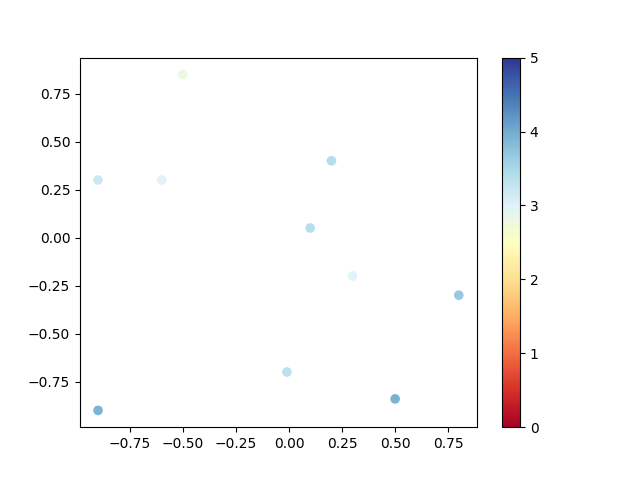

<IPython.core.display.Javascript object>


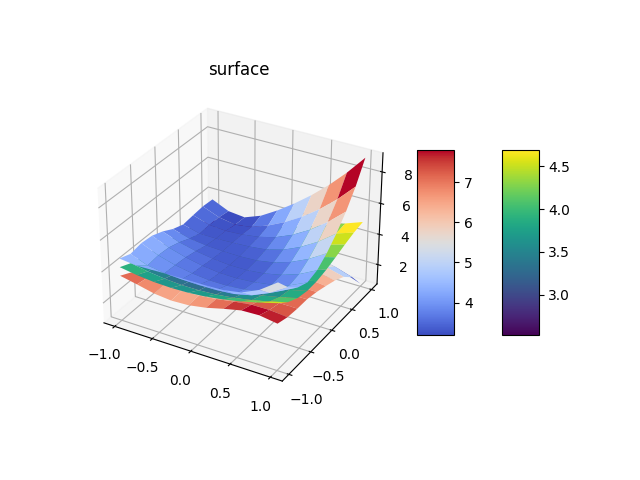

<IPython.core.display.Javascript object>


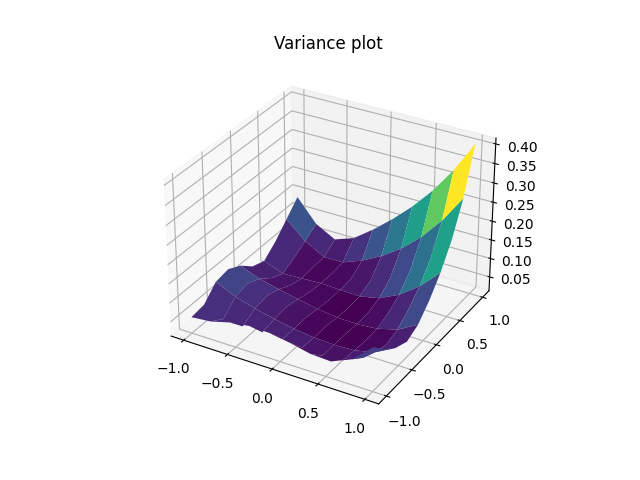

In [14]:

# Extracting only the diaginal elements: variance from covariance matrix
var = np.diag(cov).reshape(-1,1)

# converting from list of means to meshgrid format
pred_mean = mean.reshape(-1,1).reshape(num_div,num_div)
pred_var = var.reshape(-1,1).reshape(num_div,num_div)

beta = 10
upper_confidence_layer = pred_mean + beta*np.sqrt(pred_var)
lower_confidence_layer = pred_mean - beta*np.sqrt(pred_var)

# plot original points
plt.figure()
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(train_x_0, train_y_0, c=train_output_0, vmin=0, vmax=5, s=35, cmap=cm)
plt.colorbar(sc)

# plotting mesh data
fig = plt.figure()
ax = plt.axes(projection='3d')
p1 = ax.plot_surface(X, Y, pred_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
p2 = ax.plot_surface(X, Y, upper_confidence_layer, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
p3 = ax.plot_surface(X, Y, lower_confidence_layer, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
fig.colorbar(p1, shrink=0.5, aspect=5)
fig.colorbar(p2, shrink=0.5, aspect=5)
ax.set_title('surface');

#Plot only the variance
var_layer = np.sqrt(pred_var)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Variance plot')
p1 = ax.plot_surface(X, Y, var_layer, rstride=2, cstride=1,
                cmap='viridis', edgecolor='none')


## Process given data 1

In [21]:
train_x_1 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9, 4.500000000000000111e-01, 7.199999999999999734e-01, -8.000000000000000444e-01, -8.000000000000000444e-01])
train_y_1 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9, 6.500000000000000222e-01, -6.400000000000000133e-01, -6.500000000000000222e-01, 5.999999999999999778e-01])
train_output_1 = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616, 3.368086692765749124e+00, 3.752857874639865532e+00, 3.420476373601408770e+00, 3.040183158829708354e+00]).reshape(-1,1);
train_input_1 = np.concatenate((train_x_1.reshape(-1,1),train_y_1.reshape(-1,1)),axis=1)

# generate test data
num_div = 10
x1 = np.linspace(-1,1,num_div)#.reshape(-1,1)
y1 = np.linspace(-1,1,num_div)#.reshape(-1,1)
X1, Y1 = np.meshgrid(x1,y1)

# converting from meshgrid format to a list of points
pred_input = np.concatenate((X1.reshape(-1,1),Y1.reshape(-1,1)),axis=1)
noise_cov = 0.001
mean_func = lambda x: np.zeros((x.shape[0],1))

kernel, params = train_gp(train_x_1, train_y_1, train_output_1)
print(f"Data 1: kernel: {kernel.__name__}, params:{params}")
mean1, cov1 = gpr(train_input_1, train_output_1, pred_input, noise_cov * np.ones((train_input_1.shape[0])), mean_func, kernel, params)


optimizing kernel : sqexp, initial parameter :[1. 3. 2.]
Optimized parameter for this kernel:  [4.40675083 7.85236556 2.31051386]


ALL kernel optimization finished 

Original parameter (negative)likelihoods for all kernels  [106.01918156434576]
Optimized parameter (negative)likelihoods for all kernels [58.01867512710214]

 Make sure that NEW PARAMETERS (negative) likelihood < OLD PARAMETER (negative) likelihood
Data 1: kernel: sqexp, params:[4.40675083 7.85236556 2.31051386]


### Plot given data 1

<IPython.core.display.Javascript object>


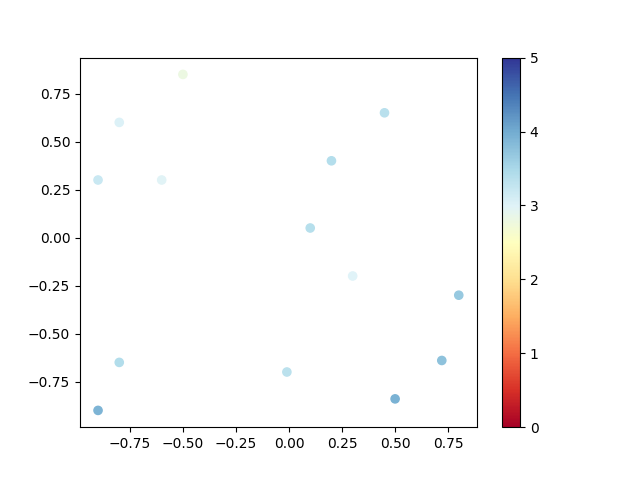

<IPython.core.display.Javascript object>


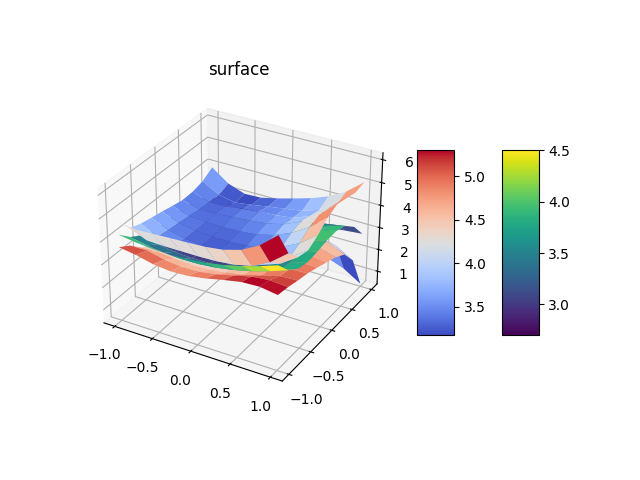

<IPython.core.display.Javascript object>


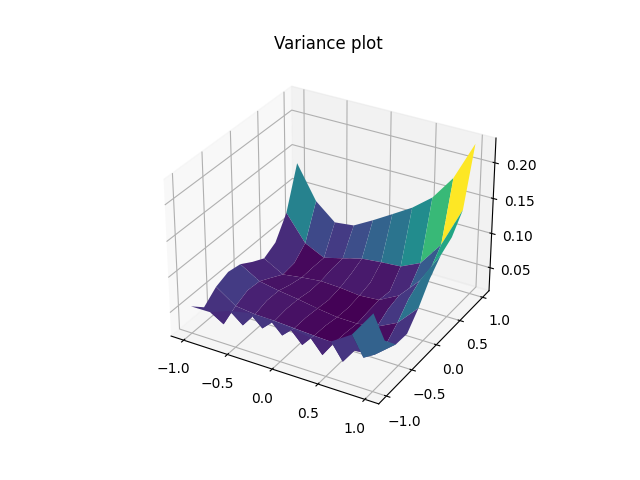

In [20]:

# Extracting only the diaginal elements: variance from covariance matrix
var1 = np.diag(cov1).reshape(-1,1)

# converting from list of means to meshgrid format
pred_mean1 = mean1.reshape(-1,1).reshape(num_div,num_div)
pred_var1 = var1.reshape(-1,1).reshape(num_div,num_div)

beta = 10
upper_confidence_layer1 = pred_mean1 + beta*np.sqrt(pred_var1)
lower_confidence_layer1 = pred_mean1 - beta*np.sqrt(pred_var1)

# plot original points
fig = plt.figure()
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(train_x_1, train_y_1, c=train_output_1, vmin=0, vmax=5, s=35, cmap=cm)
fig.colorbar(sc)

# plotting mesh data
fig = plt.figure()
ax = plt.axes(projection='3d')
p1 = ax.plot_surface(X1, Y1, pred_mean1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
p2 = ax.plot_surface(X1, Y1, upper_confidence_layer1, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
p3 = ax.plot_surface(X1, Y1, lower_confidence_layer1, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
fig.colorbar(p1, shrink=0.5, aspect=5)
fig.colorbar(p2, shrink=0.5, aspect=5)
ax.set_title('surface');

#Plot only the variance
var_layer1 = np.sqrt(pred_var1)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Variance plot')
p1 = ax.plot_surface(X1, Y1, var_layer1, rstride=2, cstride=1,
                cmap='viridis', edgecolor='none')
